In [1]:
%matplotlib inline

from __future__ import division
import os
import sys
from scipy import integrate, optimize

from scipy.interpolate import interp2d, interp1d

import numpy as np
from numpy import pi,sin,cos,tan,e,arctan,arcsin,arccos,sqrt
from numpy.random import randn
import matplotlib
import matplotlib.pyplot as P
from time import clock


matplotlib.rcParams['figure.figsize'] = (9, 6)
P.rcParams['text.usetex'] = True  # not really needed
P.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
P.rcParams["font.size"] = 24
P.rc('xtick', labelsize=20) 
P.rc('ytick', labelsize=20)
# P.rc('xtick', labelsize=20) 
# P.rc('ytick', labelsize=20)
np.set_printoptions(threshold=np.nan)


# sys.path.append("/Users/amadeus/Documents/10.semester/ma")
# from magmod import P_cdm_BBKS, D_z, rCom, H_0, c, H_z, E_z, Omega_m, W_tophat, T_obs, nutoz21, h
# from magmod import P_cdm_BBKS, D_z, rCom, H_0, c, H_z, E_z, Omega_m, T_obs, nutoz21, h
from magmod import *
from magbias_experiments import SKA_zhangpen, CLAR_zhangpen, SKA, cb_hirax as hirax, hirax512, LSST, LSST_nosgfit, n


sigma_8_BBKS = 0.833959881058

#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$ 
Rescaling the galaxy number density by a factor of 103811.592208 to match the gold sample with 6330073646.61 total galaxies 
#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$ 



In [2]:
########################################################################
########################################################################
############SETTING UP SKA B1:####################################




#fg:
b1_nutot= 435.              # Total bandwidth of *entire* survey [MHz]
b1_numax= 1015.           # Max. freq. of survey

zmin_b1, zmax_b1, zf_b1, dzf_b1 = get_fg_bin_for_frequency_range(b1_nutot, b1_numax)




############SETTING UP SKA B2:####################################
########################################################################
#######################################################################




#fg:
b2_nutot= 470.          # Total bandwidth of *entire* survey [MHz]
b2_numax= 1420.        # Max. freq. of survey


zmin_b2, zmax_b2, zf_b2, dzf_b2 = get_fg_bin_for_frequency_range(b2_nutot, b2_numax)

buffer_z = 0.1 #buffer between fg and bg to avoid correlation, 



########################################################################
########################################################################
############SETTING UP SKA B1:####################################




#fg:
b1_nutot= 435.              # Total bandwidth of *entire* survey [MHz]
b1_numax= 1015.           # Max. freq. of survey

zmin_b1, zmax_b1, zf_b1, dzf_b1 = get_fg_bin_for_frequency_range(b1_nutot, b1_numax)




############SETTING UP SKA B2:####################################
########################################################################
#######################################################################




#fg:
b2_nutot= 470.          # Total bandwidth of *entire* survey [MHz]
b2_numax= 1420.        # Max. freq. of survey


zmin_b2, zmax_b2, zf_b2, dzf_b2 = get_fg_bin_for_frequency_range(b2_nutot, b2_numax)

#bg:

mso_b2 = [21.00097656]
zbmin_b2, zbmax_b2, zb_b2, dzb_b2 = get_bg_bin_for_fgzmax(zmax_b2, mso_b2, bufferz = buffer_z)



# and now a quick illustration of the behaviour of the lensing kernel:

fg bg distance is 0.1z
1.3721766959693396 0.0
Using non default rmax = 23 for experiment
Using non default rmax = 23 for experiment
Using non default rmax = 23 for experiment
fg bg distance is 0.1z
2.2088879593508413 0.0
Using non default rmax = 25 for experiment
Using non default rmax = 25 for experiment
Using non default rmax = 25 for experiment
fg bg distance is 0.1z
2.5395274691236374 0.0
Using non default rmax = 27 for experiment
Using non default rmax = 27 for experiment
Using non default rmax = 27 for experiment


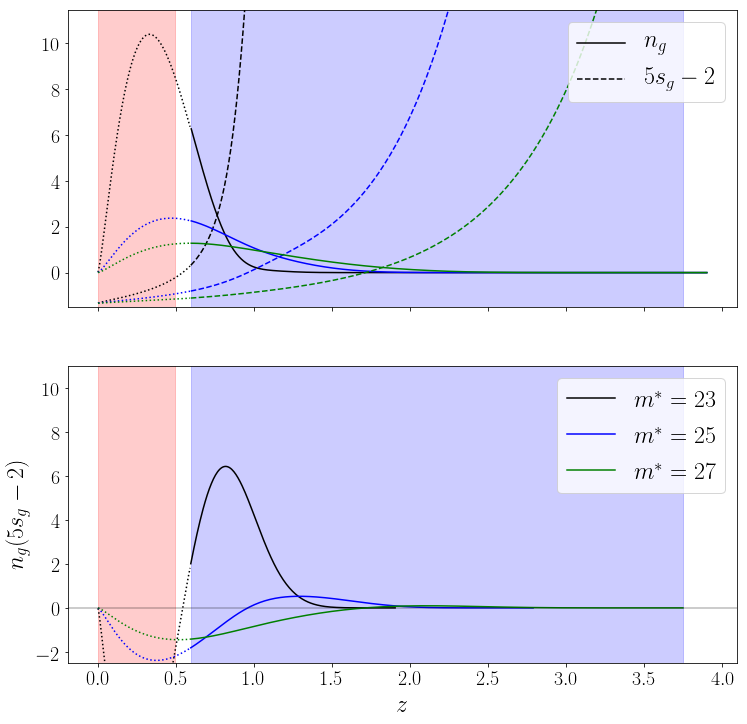

In [4]:
#################
#plot the foreground range and background dndz as well as 5sg-2:

ztab = np.linspace(0.001, 3.9,1000)
# fig = P.figure(); ax= fig.add_subplot(111);
fig, allax = P.subplots(2,1, sharex = True, figsize = (12,12))
ax = allax[0]
ax2 = allax[1]

ymax_now = [] #to set the y limits later

colors = ['black', 'blue', 'green']

rtab = [23,25,27]
for irr in np.arange(len(rtab)):
    rr = rtab[irr]
    
    #set colors and labels:
    c = colors[irr]
    
    if irr == 0:
        axnzlab = r"$n_g$"
        axsglab = r"$5s_g-2$"
    else:
        axnzlab = ""
        axsglab = ""
    
    #bg range for mstar:
#     zbbbmax = zmax_of_MAXMAG(rr)
    zbbbmin_b2, zbbbmax_b2, zbbb_b2, dzbbb_b2 = get_bg_bin_for_fgzmax(zmax_b2, rr, bufferz = buffer_z)
    print "fg bg distance is {}z".format(zbbbmin_b2-zmax_b2)

    if irr == 2:
#     if irr == 2 or irr == 1 or irr == 0:
        for axx in allax:
            axx.fill_between( np.array( [zbbbmin_b2, zbbbmax_b2]), -10, 100, color = 'blue', alpha = 0.2)
#             axx.fill_between( np.array( [zbbbmin_b2, 4.]), -10, 100, color = 'blue', alpha = 0.1)


    Wtab = W_dndz(ztab, zbbbmin_b2, zbbbmax_b2, rr, FIT = False)
    Wtab_outside = W_dndz(ztab, zmin_b2, zbbbmin_b2, rr, FIT = False)
    transition_i = np.abs(ztab - zbmin_b2).argmin()
    norm = Wtab_outside[transition_i]/Wtab[transition_i + 1]
    print Wtab_outside[transition_i],Wtab[transition_i]
    Wtab_outside /= norm

    ax.plot(ztab[transition_i+1:], Wtab[transition_i+1:], c = c, label = axnzlab)
    ax.plot(ztab[:transition_i], Wtab_outside[:transition_i],c = c, ls = ":")

    Woutmax = np.amax(Wtab_outside)
    Wmax = np.amax(Wtab)
    ymax_now.append( np.amax((Woutmax, Wmax)) )
    
    #background redshift only:
    zbtab = np.linspace(zbbbmin_b2, zbbbmax_b2, 200)
    sgtab = sg5minus2(zbtab, rr )
    
    sgtab_outside = sg5minus2(ztab, rr)[:transition_i]
    
    ax.plot(zbtab, sgtab, c = c, ls = "--", label = axsglab)
    ax.plot(ztab[:transition_i], sgtab_outside, ls = ":", c =c)
    
    Wtab_inside = W_dndz(zbtab, zbbbmin_b2, zbbbmax_b2, rr, FIT = False)
    ax2.plot(zbtab, Wtab_inside * sgtab, c=c, label = r"$m^* = {}$".format(rr))
    
    #outside bg redshift only:
    sgtab_outside = sg5minus2(ztab, rr )
    ax2.plot(ztab[:transition_i], Wtab_outside[:transition_i]*sgtab_outside[:transition_i],c = c, ls = ":")
    
#     Nnorm = dndz_norm(zbbbmin_b2, zbbbmax_b2, rr, FIT = False)
#     sgngtab = sgng_interp(ztab, rr)/Nnorm
#     ax2.plot(ztab, sgngtab, color = 'red', ls = ":")



#fg redshift range:
ax.fill_between( np.array( [zmin_b2, zmax_b2]), -10, 100, color = 'red', alpha = 0.2)
ax2.fill_between( np.array( [zmin_b2, zmax_b2]), -10, 100, color = 'red', alpha = 0.2)

#horizontal line at 0 for ax2:
ax2.axhline(0, c = 'black', lw = 0.4)

ymax = np.amax(ymax_now)
ax.set_ylim((-1.5,ymax*1.1))
ax2.set_ylim((-2.5,11))

ax2.set_xlabel(r"$z$")
ax2.set_ylabel(r"$n_g (5s_g-2)$")

ax.legend(loc = "upper right")
ax2.legend(loc = "upper right")

plotdir = "/Users/amadeus/Documents/PhD/work/MagBias/plots/"
# plotdir = "/Users/amadeus/Documents/PhD/Thesis/tex/images/"
# print "we are saving plot to thesis!!!!"

P.savefig( plotdir + "W_and_sg_SKAB2.pdf")